# LSTM models for multivariate Time Series forecastings

## Sommaire

- [I. Préparation des données](#present_data)

- [II. Construction de 2 models LSTM](#LSTM)
    - [II.A LSTM avec des TS non stationarisées](#LSTMA)
    - [II.B LSTM avec des TS stationarisées](#LSTMB)


In [1]:
rm(list=ls())
suppressPackageStartupMessages(require(skimr))
suppressPackageStartupMessages(require(readxl))
suppressPackageStartupMessages(require(stringr))
suppressPackageStartupMessages(require(dplyr))
suppressPackageStartupMessages(require(ggplot2))
suppressPackageStartupMessages(require(forecast))

<div id="present_data">

# I . Data preparation

In [2]:
#------------------------------------------------------
# data pre treatment (similar to univariate case)

df <- read_excel("data/data.xlsx",sheet = 3)
tmp <-df%>% filter(aire=="44_GRAND EST" & champ=="ESS")

df <-tmp[-which(!is.na(tmp$secret_stat)),]%>%select(-secret_stat)
df <- df %>% select(-champ,-type_aire,-type_naf,-aire)
df <- df[,c(TRUE,str_detect(colnames(df),"nb_etab")[-1])]
tmp <- t(df)
colnames(tmp) <- tmp[1,]
tmp <-tmp[-1,]
df <- tmp
tmp <-df%>%as.data.frame
tmp <-cbind("date"=rep(NA,nrow(tmp)),tmp)
for (i in 1:nrow(tmp)){
    tmp.format.date <- strsplit(rownames(df)[i],"nb_etab")[[1]][2]
    subsplit <-strsplit(tmp.format.date,"T")[[1]]
    year<-subsplit[1]
    trimester <- subsplit[2]
    month <-switch(trimester,
        "1"="01",
        "2"="04",
        "3"="07",
        "4"="10"
    )
    tmp[i,1] <- paste(year,month,"01",sep="-")
}
tmp$date <-as.Date(tmp$date)
rownames(tmp) <- NULL

df.indexes <-which(tmp$date < as.Date("2020-01-01"))
train.indexes<- which(tmp$date < as.Date("2018-01-01") )
test.indexes <-which(tmp$date>= as.Date("2018-01-01") & tmp$date <as.Date("2020-01-01") )
tmp <-tmp %>%select(-date)%>% mutate_all(as.numeric)
#----------------------------
# Eliminate total serie
tmp <- tmp[,-ncol(tmp)]
df.ts <- ts(tmp[df.indexes,],start=c(2010,1),frequency=4)# S'arrete à 2019 Q4
train.ts <-ts(tmp[train.indexes,],start=c(2010,1),frequency = 4)# S'arrete à 2017 Q4
test.ts <-ts(tmp[test.indexes,],start = c(2018,1),frequency = 4)# Commence a 2018 Q1 --> 2019 Q4
global.ts <- ts(tmp,start=c(2010,1),frequency=4)# Commence a 2010 Q1 --> 2021 Q2
covid.ts <- ts(tmp[(df.indexes[length(df.indexes)]+1):nrow(tmp),],start=c(2020,1),frequency = 4)# Commence a 2020 Q1 --> 2021 Q2

In [3]:
require(tensorflow)
require(keras)

Loading required package: tensorflow

Loading required package: keras



In [4]:
lab.to.num <-cbind("lab"=colnames(df.ts),"num"=1:length(colnames(df.ts))) %>%as.data.frame
lab.to.num$num <- as.numeric(lab.to.num$num)
colnames(df.ts) <-lab.to.num$num

In [5]:
df.train <-df.ts %>% as.data.frame

In [6]:
#-----------------------------
# Scaled the train sample and get the sample factor parmas: mean + sd
scaled_train <- scale(df.train)
scale_factor <-list("center"=attr(scaled_train,"scaled:center"),"sd"=attr(scaled_train,"scaled:scale"))

In [8]:
#----------------
# We d like to do a 6 Quarter forecast,
# We need to base each prediction on 6 points
prediction <- 6
lag <- prediction

In [10]:

x_train_data <-t(sapply(
    1:(dim(scaled_train)[1]-lag-prediction +1),
    function(x){scaled_train[x:(x+lag-1),1]}
))

for(i in 2:ncol(scaled_train)){
    new <-t(sapply(
        1:(dim(scaled_train)[1]-lag-prediction +1),
        function(x){scaled_train[x:(x+lag-1),i]}
    ))
    x_train_data <-cbind(x_train_data,new)
    
}

In [11]:
cat("Shape de  X_train :",x_train_data%>% dim)

Shape de  X_train : 29 156

In [12]:
x_train_arr <- array(
    data=as.numeric(unlist(x_train_data)),
    dim=c(
        nrow(x_train_data),
        ncol(x_train_data),
        1
        )

)


In [13]:
y_train_data <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))
y_train_arr <-array(
    data=as.numeric(unlist(y_train_data)),
    dim=c(
        nrow(y_train_data),
        prediction,
        1
    )
)

In [14]:
x_test <-df.train[(nrow(scaled_train)- prediction+1):nrow(scaled_train),]
for(i in 1:ncol(x_test)){
    x_test[,i] <-(x_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
x_test_scaled <- x_test[,1]

In [15]:
x_test

,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
35,-1.431074,-0.2819201,0.02739667,-0.2392895,-2.037024,-0.8231048,1.094363,1.049924,1.325868,-1.07950734,⋯,0.09966473,-1.83878403,-2.319888,-0.8215552,-1.8710760,-0.9745028,-1.656126,-1.56195820,-1.770070,1.443310
36,-1.472877,-0.2167363,0.02739667,-0.7566721,-1.767962,-0.8231048,1.094363,1.239955,1.403122,-0.93509164,⋯,-0.90843824,0.15582916,-1.831491,-0.8215552,-1.5163697,-1.1985265,-1.701375,-0.23505196,-1.681677,1.847033
37,-1.584354,0.1743668,0.02739667,-0.7566721,-1.902493,-0.3841156,1.593692,1.810049,1.596256,-0.93509164,⋯,-0.81679252,0.40515580,-1.343093,-0.8215552,-1.3390165,-1.4225501,-1.837123,-1.14493053,-2.167838,1.443310
38,-1.667961,-0.6730231,0.02739667,-0.7566721,-1.835227,0.4938629,1.760135,1.620018,1.634883,-1.07950734,⋯,-0.63350107,1.40246240,-1.343093,-0.1223593,-0.9843101,-0.9745028,-1.882372,0.52318017,-1.946856,1.645172
39,-1.849109,-0.6730231,1.12326335,-0.4979808,-1.835227,-0.3841156,1.593692,1.429987,1.789390,-0.35742885,⋯,0.23713331,0.15582916,-1.343093,-0.4719573,-1.6937228,-1.1985265,-1.565627,-1.71360463,-2.189936,1.847033
40,-1.904847,-0.8685747,2.21913003,-0.4979808,-1.498900,-0.3841156,1.510471,1.239955,1.789390,0.07581824,⋯,-0.81679252,-0.09349749,-1.343093,-0.8215552,-1.1616633,-0.7504792,-1.746624,-0.08340554,-2.234133,2.654480


In [16]:
x_pred_arr <- array(
    data=x_test,
    dim=c(1,lag,1)
)

In [17]:
cat("\nX test scaled :",x_test_scaled)


X test scaled : -1.431074 -1.472877 -1.584354 -1.667961 -1.849109 -1.904847

<hr>

<div id="LSTM">

# II. Construct LSTM models

<div id="LSTMA">

## II.A : LSTM model with non stable TS

In [18]:
x_train_arr %>%dim
y_train_arr %>%dim

[1]  29 156   1

[1] 29  6  1

In [19]:

x_bis <-sapply(
        1:ncol(scaled_train),
        function(x){scaled_train[1:(29-1+1),x]}
)

x_bis_first_array <-array(
    data=unlist(x_bis),
    dim=c(nrow(x_bis),1,ncol(x_bis))
)
tot_array <-array(NA, dim=c(
    nrow(x_bis),
    6,
    ncol(x_bis)
))
tot_array[,1,] <- x_bis_first_array


for (i in 2:6){
    new <-sapply(
        1:ncol(scaled_train),
        function(x){scaled_train[i:(i+29-1),x]}
    )
    new <- array(
        data=unlist(new),
        dim=c(nrow(x_bis),1,ncol(x_bis))
    )
    tot_array[,i,] <- new
}
x_train_arr_bis <- tot_array


In [20]:

y_train_data_bis <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))

tot_array <-array(NA, dim=c(
    nrow(y_train_data_bis),
    6,
    ncol(scaled_train)
))

tot_array[,,1] <- y_train_data_bis

for (i in 2:ncol(scaled_train)){
    new <-  t(sapply(
        (1+lag):(dim(scaled_train)[1]-prediction +1),
        function(x){scaled_train[x:(x+prediction-1),i]}
    ))

    new_array <- array(
        data=as.numeric(unlist(new)),
        dim=c(nrow(new),
        ncol(new),
        1)
    )
    tot_array[,,i] <- new_array

}

y_train_arr_bis <- tot_array


In [21]:

x_train_arr_bis%>%dim
y_train_arr_bis %>% dim

[1] 29  6 26

[1] 29  6 26

In [22]:
LSTM_model <- keras_model_sequential()

LSTM_model%>% layer_lstm(
    units=50,
    batch_input_shape=c(1,6,26),#BATCH size , timestep ,features
    return_sequences=T,
    stateful=T

)%>%
layer_dropout(rate=0.5)%>%layer_lstm(
    units =50,
    return_sequences=T,stateful=T
)%>% layer_dropout(rate=0.5)%>% time_distributed(keras::layer_dense(units=26))

Loaded Tensorflow version 2.9.1



In [23]:
LSTM_model %>% compile(loss='mae',optimizer='adam',metrics='accuracy')
summary(LSTM_model)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm_1 (LSTM)                      (1, 6, 50)                      15400       
 dropout_1 (Dropout)                (1, 6, 50)                      0           
 lstm (LSTM)                        (1, 6, 50)                      20200       
 dropout (Dropout)                  (1, 6, 50)                      0           
 time_distributed (TimeDistributed)  (1, 6, 26)                     1326        
Total params: 36,926
Trainable params: 36,926
Non-trainable params: 0
________________________________________________________________________________


In [24]:
LSTM_model %>% keras::fit(
    x=x_train_arr_bis,
    y=y_train_arr_bis,
    batch_size=1,
    epochs=20,# Number of times to iterate over the training data
    verbose=2,
    shuffle=FALSE
)

In [25]:
x_test <-df.train[(nrow(scaled_train)- prediction+1):nrow(scaled_train),]
for(i in 1:ncol(x_test)){
    x_test[,i] <-(x_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
x_test_scaled <- x_test
x_test_scaled

,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
35,-1.431074,-0.2819201,0.02739667,-0.2392895,-2.037024,-0.8231048,1.094363,1.049924,1.325868,-1.07950734,⋯,0.09966473,-1.83878403,-2.319888,-0.8215552,-1.8710760,-0.9745028,-1.656126,-1.56195820,-1.770070,1.443310
36,-1.472877,-0.2167363,0.02739667,-0.7566721,-1.767962,-0.8231048,1.094363,1.239955,1.403122,-0.93509164,⋯,-0.90843824,0.15582916,-1.831491,-0.8215552,-1.5163697,-1.1985265,-1.701375,-0.23505196,-1.681677,1.847033
37,-1.584354,0.1743668,0.02739667,-0.7566721,-1.902493,-0.3841156,1.593692,1.810049,1.596256,-0.93509164,⋯,-0.81679252,0.40515580,-1.343093,-0.8215552,-1.3390165,-1.4225501,-1.837123,-1.14493053,-2.167838,1.443310
38,-1.667961,-0.6730231,0.02739667,-0.7566721,-1.835227,0.4938629,1.760135,1.620018,1.634883,-1.07950734,⋯,-0.63350107,1.40246240,-1.343093,-0.1223593,-0.9843101,-0.9745028,-1.882372,0.52318017,-1.946856,1.645172
39,-1.849109,-0.6730231,1.12326335,-0.4979808,-1.835227,-0.3841156,1.593692,1.429987,1.789390,-0.35742885,⋯,0.23713331,0.15582916,-1.343093,-0.4719573,-1.6937228,-1.1985265,-1.565627,-1.71360463,-2.189936,1.847033
40,-1.904847,-0.8685747,2.21913003,-0.4979808,-1.498900,-0.3841156,1.510471,1.239955,1.789390,0.07581824,⋯,-0.81679252,-0.09349749,-1.343093,-0.8215552,-1.1616633,-0.7504792,-1.746624,-0.08340554,-2.234133,2.654480


In [26]:

x_test_array <- array(
    data = as.numeric(unlist(x_test_scaled)),
    dim=c(1,6,26)
)

[1]  6 26

In [27]:
x_test_array %>%dim

[1]  1  6 26

In [28]:
LSTM_forecast <- LSTM_model %>% predict(x_test_array,batch_size=1)
LSTM_forecast %>%dim

[1]  1  6 26

In [29]:
LSTM_forecast[,,1] 

[1] -1.579269 -1.579899 -1.611154 -1.607770 -1.639597 -1.636457

In [30]:
# Unscale prediction
for (i in 1: dim(LSTM_forecast)[3]){
    LSTM_forecast[,,i] <- LSTM_forecast[,,i] * scale_factor[["sd"]][i] +scale_factor[["center"]][i]
}

In [31]:
LSTM_forecast[,,1]

[1] 1086.365 1086.320 1084.077 1084.320 1082.036 1082.261

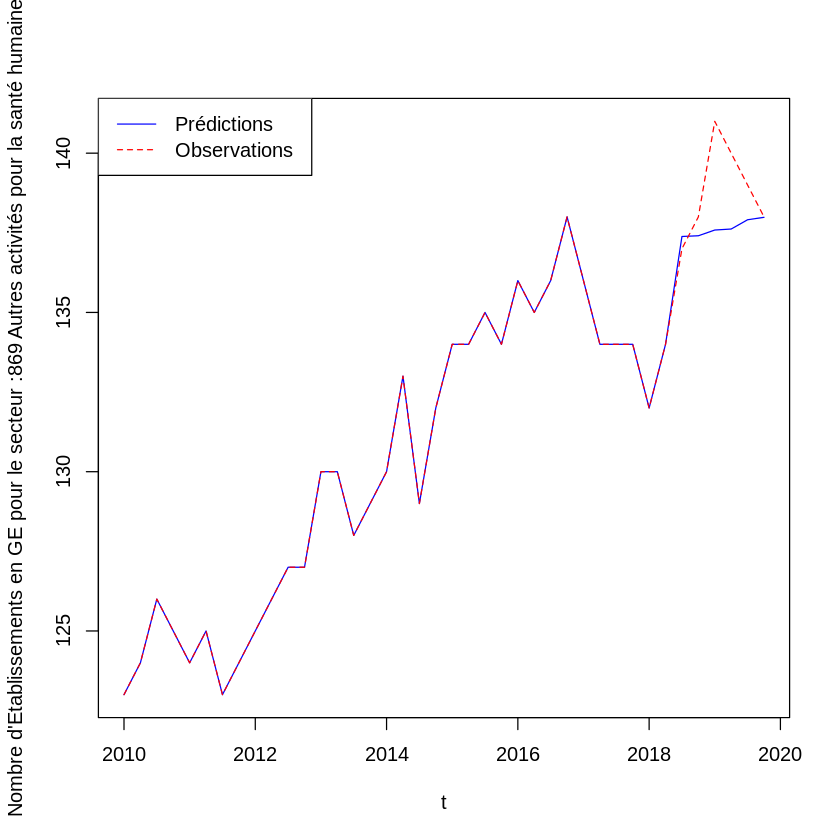

In [32]:
index_secteur <- 8
pred <-c(df.ts[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast[,,index_secteur])
pred <-ts(pred, start=c(2010,1),frequency=4)
obs <- df.ts[,index_secteur]

plot.ts(
    cbind(pred,obs),
    plot.type="single",
    lty=c(1,2),
    lwd=1,
    xlab="t",
    ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[index_secteur],sep=""),
    
    col=c("blue","red")
)
legend("topleft",

    legend=c("Prédictions","Observations"),
    col=c("blue","red"),
    lty=c(1,2),
    lwd=1
)

<hr>

### Save results

In [52]:
#-------------------------------
#Save all plots
for( index_secteur in 1:ncol(scaled_train)){

    png(file=paste("plots/LSTM_non_stable/",index_secteur,".png",sep=""))
    pred <-c(df.ts[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast[,,index_secteur])
    pred <-ts(pred, start=c(2010,1),frequency=4)
    obs <- df.ts[,index_secteur]

    plot.ts(
        cbind(pred,obs),
        plot.type="single",
        main=paste("Predictions LSTM non stable vs observations \n secteur : ",lab.to.num$lab[index_secteur],sep=""),
        col=c("blue","red"),
        lty=c(2,1),
        lwd=1,
        xlab="t",
        ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[index_secteur],sep=""),

    )
    legend("topleft",
        legend=c("Prédictions","Observations"),
        col=c("blue","red"),
        lty=c(2,1),
        lwd=1
)
    dev.off()
}

In [35]:
#----------------------
#Save models
save_model_tf(LSTM_model,"models/LSTM_non_stable")

<hr>

<div id="LSTMB">

## II.B LSTM model with stable TS

In [64]:
df.diff <-diff(df.ts)
df.train <-df.diff%>%as.data.frame
scaled_train <- scale(df.train)
scale_factor <-list("center"=attr(scaled_train,"scaled:center"),"sd"=attr(scaled_train,"scaled:scale"))
prediction <- 6
lag <- prediction

In [68]:
x_train_data <-t(sapply(
    1:(dim(scaled_train)[1]-lag-prediction +1),
    function(x){scaled_train[x:(x+lag-1),1]}
))

for(i in 2:ncol(scaled_train)){
    new <-t(sapply(
        1:(dim(scaled_train)[1]-lag-prediction +1),
        function(x){scaled_train[x:(x+lag-1),i]}
    ))
    x_train_data <-cbind(x_train_data,new)
    
}

x_train_arr <- array(
    data=as.numeric(unlist(x_train_data)),
    dim=c(
        nrow(x_train_data),
        ncol(x_train_data),
        1
        )

)
x_train_arr %>%dim

[1]  28 156   1

In [69]:
y_train_data <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))
y_train_arr <-array(
    data=as.numeric(unlist(y_train_data)),
    dim=c(
        nrow(y_train_data),
        prediction,
        1
    )
)
y_train_arr%>%dim

[1] 28  6  1

In [70]:
x_test <-df.train[(nrow(scaled_train)- prediction+1):nrow(scaled_train),]
for(i in 1:ncol(x_test)){
    x_test[,i] <-(x_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
x_test_scaled <- x_test[,1]

In [71]:
x_test

,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
34,-0.339129297,0.27574168,-0.07250747,0.6807629,-1.3878366,-0.67485091,-0.5016331,1.5151134,1.33269168,-0.5840227,⋯,1.0589631,-0.9439893,-0.61245961,-0.5145595,-1.2109560,0.8919034,0.46265195,-1.297037,-1.12764156,1.2446400
35,0.116941137,0.05627381,-0.07250747,-0.9447322,0.5760831,-0.04820364,-0.2630515,0.3564973,-0.07203739,0.5548215,⋯,-0.9181435,1.8521309,0.75245037,0.0588068,0.6674019,-0.3653580,0.08674724,1.068196,0.38785591,0.7442177
36,-0.090363606,0.60494348,-0.07250747,0.1389312,-0.1309280,0.57844364,1.1684382,1.5151134,0.77080005,0.1752068,⋯,0.1363133,0.2210608,0.75245037,0.0588068,0.3990651,-0.3653580,-0.28915747,-0.792454,-1.09904726,-1.2574713
37,-0.007441709,-1.48000125,-0.07250747,0.1389312,0.2225776,1.20509091,0.2141117,-0.8021188,-0.35298320,-0.2044079,⋯,0.2241847,0.9200908,0.06999538,1.2055394,0.6674019,0.8919034,0.08674724,1.352024,0.73098741,0.2437955
38,-0.297668349,-0.05346012,1.81268664,0.6807629,0.1047424,-1.30149818,-0.7402147,-0.8021188,0.48985424,2.0732805,⋯,0.8832203,-1.1769993,0.06999538,-0.5145595,-0.9426192,-0.3653580,1.59036606,-1.896229,-0.46997285,0.2437955
39,0.075480188,-0.38266192,1.81268664,0.1389312,0.6939183,-0.04820364,-0.5016331,-0.8021188,-0.63392901,1.3140510,⋯,-0.9620792,-0.2449593,0.06999538,-0.5145595,0.9357388,0.8919034,-0.47710982,1.320487,0.04472441,1.7450622


In [ ]:
x_pred_arr <- array(
    data=x_test,
    dim=c(1,lag,1)
)

In [72]:
x_train_arr %>%dim
y_train_arr %>%dim

[1]  28 156   1

[1] 28  6  1

In [77]:
x_bis <-sapply(
        1:ncol(scaled_train),
        function(x){scaled_train[1:(28-1+1),x]}
)

x_bis_first_array <-array(
    data=unlist(x_bis),
    dim=c(nrow(x_bis),1,ncol(x_bis))
)
tot_array <-array(NA, dim=c(
    nrow(x_bis),
    6,
    ncol(x_bis)
))
tot_array[,1,] <- x_bis_first_array


for (i in 2:6){
    new <-sapply(
        1:ncol(scaled_train),
        function(x){scaled_train[i:(i+28-1),x]}
    )
    new <- array(
        data=unlist(new),
        dim=c(nrow(x_bis),1,ncol(x_bis))
    )
    tot_array[,i,] <- new
}
x_train_arr_bis <- tot_array

In [79]:

y_train_data_bis <-  t(sapply(
    (1+lag):(dim(scaled_train)[1]-prediction +1),
    function(x){scaled_train[x:(x+prediction-1),1]}
))

tot_array <-array(NA, dim=c(
    nrow(y_train_data_bis),
    6,
    ncol(scaled_train)
))

tot_array[,,1] <- y_train_data_bis

for (i in 2:ncol(scaled_train)){
    new <-  t(sapply(
        (1+lag):(dim(scaled_train)[1]-prediction +1),
        function(x){scaled_train[x:(x+prediction-1),i]}
    ))

    new_array <- array(
        data=as.numeric(unlist(new)),
        dim=c(nrow(new),
        ncol(new),
        1)
    )
    tot_array[,,i] <- new_array

}

y_train_arr_bis <- tot_array

In [80]:
x_train_arr_bis%>%dim
y_train_arr_bis %>% dim

[1] 28  6 26

[1] 28  6 26

In [81]:
LSTM_model <- keras_model_sequential()

LSTM_model%>% layer_lstm(
    units=50,
    batch_input_shape=c(1,6,26),#BATCH size , timestep ,features
    return_sequences=T,
    stateful=T

)%>%
layer_dropout(rate=0.5)%>%layer_lstm(
    units =50,
    return_sequences=T,stateful=T
)%>% layer_dropout(rate=0.5)%>% time_distributed(keras::layer_dense(units=26))

In [82]:
LSTM_model %>% compile(loss='mae',optimizer='adam',metrics='accuracy')
summary(LSTM_model)

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm_3 (LSTM)                      (1, 6, 50)                      15400       
 dropout_3 (Dropout)                (1, 6, 50)                      0           
 lstm_2 (LSTM)                      (1, 6, 50)                      20200       
 dropout_2 (Dropout)                (1, 6, 50)                      0           
 time_distributed_1 (TimeDistribute  (1, 6, 26)                     1326        
 d)                                                                             
Total params: 36,926
Trainable params: 36,926
Non-trainable params: 0
________________________________________________________________________________


In [83]:
LSTM_model %>% keras::fit(
    x=x_train_arr_bis,
    y=y_train_arr_bis,
    batch_size=1,
    epochs=20,# Number of times to iterate over the training data
    verbose=2,
    shuffle=FALSE
)

In [84]:
x_test <-df.train[(nrow(scaled_train)- prediction+1):nrow(scaled_train),]
for(i in 1:ncol(x_test)){
    x_test[,i] <-(x_test[,i] -scale_factor[["center"]][i])/scale_factor[["sd"]][i]
}
x_test_scaled <- x_test
x_test_scaled

,1,2,3,4,5,6,7,8,9,10,⋯,17,18,19,20,21,22,23,24,25,26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
34,-0.339129297,0.27574168,-0.07250747,0.6807629,-1.3878366,-0.67485091,-0.5016331,1.5151134,1.33269168,-0.5840227,⋯,1.0589631,-0.9439893,-0.61245961,-0.5145595,-1.2109560,0.8919034,0.46265195,-1.297037,-1.12764156,1.2446400
35,0.116941137,0.05627381,-0.07250747,-0.9447322,0.5760831,-0.04820364,-0.2630515,0.3564973,-0.07203739,0.5548215,⋯,-0.9181435,1.8521309,0.75245037,0.0588068,0.6674019,-0.3653580,0.08674724,1.068196,0.38785591,0.7442177
36,-0.090363606,0.60494348,-0.07250747,0.1389312,-0.1309280,0.57844364,1.1684382,1.5151134,0.77080005,0.1752068,⋯,0.1363133,0.2210608,0.75245037,0.0588068,0.3990651,-0.3653580,-0.28915747,-0.792454,-1.09904726,-1.2574713
37,-0.007441709,-1.48000125,-0.07250747,0.1389312,0.2225776,1.20509091,0.2141117,-0.8021188,-0.35298320,-0.2044079,⋯,0.2241847,0.9200908,0.06999538,1.2055394,0.6674019,0.8919034,0.08674724,1.352024,0.73098741,0.2437955
38,-0.297668349,-0.05346012,1.81268664,0.6807629,0.1047424,-1.30149818,-0.7402147,-0.8021188,0.48985424,2.0732805,⋯,0.8832203,-1.1769993,0.06999538,-0.5145595,-0.9426192,-0.3653580,1.59036606,-1.896229,-0.46997285,0.2437955
39,0.075480188,-0.38266192,1.81268664,0.1389312,0.6939183,-0.04820364,-0.5016331,-0.8021188,-0.63392901,1.3140510,⋯,-0.9620792,-0.2449593,0.06999538,-0.5145595,0.9357388,0.8919034,-0.47710982,1.320487,0.04472441,1.7450622


In [85]:
x_test_array <- array(
    data = as.numeric(unlist(x_test_scaled)),
    dim=c(1,6,26)
)

In [86]:
x_test_array %>%dim

[1]  1  6 26

In [87]:
LSTM_forecast <- LSTM_model %>% predict(x_test_array,batch_size=1)
LSTM_forecast %>%dim

[1]  1  6 26

In [88]:
LSTM_forecast[,,1] 

[1] -0.18064149 -0.09264661 -0.11496474 -0.09866706 -0.09510001 -0.03442806

In [89]:
#----------------------------------
# Remembering we did 2 operations before inputing datat in our model : 
# 1.Differenciation
# 2. Scaling

#-------------
# 1.unscale Predictions
for (i in 1: dim(LSTM_forecast)[3]){
    LSTM_forecast[,,i] <- LSTM_forecast[,,i] * scale_factor[["sd"]][i] +scale_factor[["center"]][i]
}


In [90]:
LSTM_forecast[,,1] # There are still differenciate

[1] -10.177420  -8.055064  -8.593357  -8.200272  -8.114238  -6.650886

In [95]:
df.diff

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
2010 Q2,-6,-1,2,0,9,-2,1,1,-1,-3,16,14,4,-3,-4,0,2,3,1,-2,1,2,3,41,67,1
2010 Q3,-5,2,0,0,-45,0,12,2,5,2,11,-63,15,0,17,0,36,-3,0,2,-7,2,5,-23,-35,4
2010 Q4,-1,-9,0,0,38,2,-9,-1,3,1,-27,77,-16,0,-4,0,-47,3,0,0,-6,0,-1,27,14,-3
2011 Q1,-2,46,-1,-1,-17,5,11,-1,-3,-8,2,-21,-3,1,-8,0,2,-1,1,-3,-1,0,-4,-21,-77,-2
2011 Q2,-2,1,0,-2,11,-1,1,1,6,-4,2,-28,-1,-2,-4,0,1,-1,-3,0,6,-2,5,33,51,-2
2011 Q3,-5,-2,1,4,-57,0,-1,-2,2,-1,29,-88,13,-2,-3,0,35,-4,1,3,-2,0,4,-37,-13,3
2011 Q4,-2,0,-2,-7,40,-2,0,1,3,-4,-21,93,-17,2,-5,0,-44,6,-2,0,0,4,-10,10,0,2
2012 Q1,-8,2,-2,-3,7,0,2,1,-3,-7,9,6,-3,1,-3,-7,-4,-4,-1,0,-3,2,-5,-13,3,1
2012 Q2,-2,-1,0,0,4,1,2,1,9,2,6,9,1,-1,-1,0,0,0,2,0,0,-3,-1,41,52,0
2012 Q3,-1,1,0,1,-36,1,-1,1,1,0,38,-53,13,-1,-9,0,30,-5,-1,3,-2,-5,3,-36,-25,0


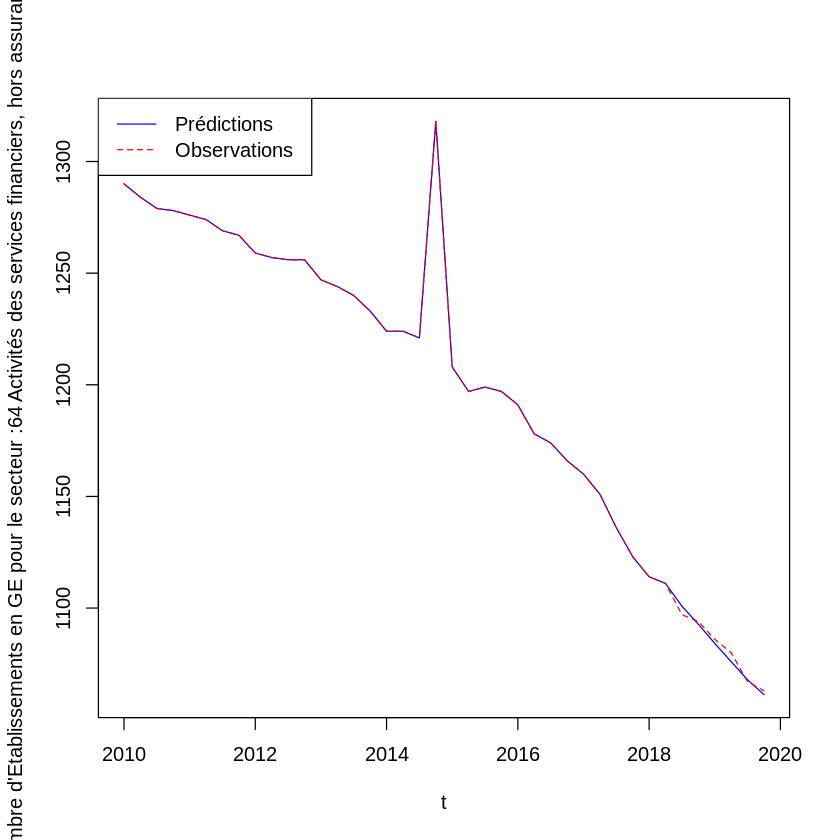

In [100]:
index_secteur <- 1
pred <- c(df.diff[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast[,,index_secteur])
pred <-ts(pred, start=c(2010,2),frequency=4)
obs <- df.diff[,index_secteur]

#-----------------
# Inverse differenciation
starting_point <- df.ts[1,index_secteur]
obs <-diffinv(obs,xi=starting_point)
pred <-diffinv(pred,xi=starting_point)
plot.ts(
    cbind(pred,obs),
    plot.type="single",
    lty=c(1,2),
    lwd=1,
    xlab="t",
    ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[index_secteur],sep=""),
    
    col=c("blue","red")
)
legend("topleft",

    legend=c("Prédictions","Observations"),
    col=c("blue","red"),
    lty=c(1,2),
    lwd=1
)

In [102]:
#-------------------------------
#Save all plots
for( index_secteur in 1:ncol(scaled_train)){

    png(file=paste("plots/LSTM_stable/",index_secteur,".png",sep=""))
    pred <- c(df.diff[1:(nrow(scaled_train)-prediction),index_secteur],LSTM_forecast[,,index_secteur])
    pred <-ts(pred, start=c(2010,2),frequency=4)
    obs <- df.diff[,index_secteur]
    
    #-----------------
    # Inverse differenciation
    starting_point <- df.ts[1,index_secteur]
    obs <-diffinv(obs,xi=starting_point)
    pred <-diffinv(pred,xi=starting_point)

    plot.ts(
        cbind(pred,obs),
        plot.type="single",
        main=paste("Predictions LSTM stable vs observations \n secteur : ",lab.to.num$lab[index_secteur],sep=""),
        col=c("blue","red"),
        lty=c(2,1),
        lwd=1,
        xlab="t",
        ylab=paste("Nombre d'Etablissements en GE pour le secteur :",lab.to.num$lab[index_secteur],sep=""),

    )
    legend("topleft",
        legend=c("Prédictions","Observations"),
        col=c("blue","red"),
        lty=c(2,1),
        lwd=1
)
    dev.off()
}